# Target Engineering - Directional

Directional targets are essential in quantitative trading for building models that predict the **market direction** (e.g., bullish vs. bearish scenarios). By transforming raw price data into **binary or multi-class labels**, directional targets help structure classification problems for systematic trading strategies. In this notebook, we will generate and analyze **directional targets** using the `quantreo` package to improve signal clarity and model decision-making under varying market regimes.

In [1]:
# Import the Target Engineering Package from Quantreo
import quantreo.target_engineering as te

# To display the graphics
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

In [2]:
# Import a dataset to test the functions and create new ones easily
from quantreo.datasets import load_generated_ohlcv
df = load_generated_ohlcv()
df = df.loc["2016"]

# Show the data
df

,open,high,low,close,volume
time,,,,,
2016-01-04 00:00:00,104.944241,105.312073,104.929735,105.232289,576.805768
2016-01-04 04:00:00,105.233361,105.252139,105.047564,105.149357,485.696723
2016-01-04 08:00:00,105.159851,105.384745,105.141110,105.330306,403.969745
2016-01-04 12:00:00,105.330306,105.505799,104.894155,104.923404,1436.917324
2016-01-04 16:00:00,104.914147,105.023293,104.913252,105.014347,1177.672605
...,...,...,...,...,...
2016-12-30 04:00:00,103.632257,103.711884,103.495896,103.564574,563.932484
2016-12-30 08:00:00,103.564574,103.629321,103.555581,103.616731,697.707475
2016-12-30 12:00:00,103.615791,103.628165,103.496810,103.515847,1768.926665


<br>

## **Future Returns Sign**

The `future_returns_sign` function generates a **binary directional target** based on future returns.

- It computes the return between the current price and the price `window_size` steps ahead.
- Then it assigns a **positive label** (default `1`) if the return is strictly positive, otherwise a **negative label** (default `0`).

This target is ideal for **trend-following models** or binary classification.


In [3]:
df["label"] = te.directional.future_returns_sign(df, close_col='close', window_size=10, log_return=True)
df["label"]

time
2016-01-04 00:00:00    1
2016-01-04 04:00:00    1
2016-01-04 08:00:00    1
2016-01-04 12:00:00    1
2016-01-04 16:00:00    1
                      ..
2016-12-30 04:00:00    0
2016-12-30 08:00:00    0
2016-12-30 12:00:00    0
2016-12-30 16:00:00    0
2016-12-30 20:00:00    0
Name: label, Length: 1548, dtype: int64

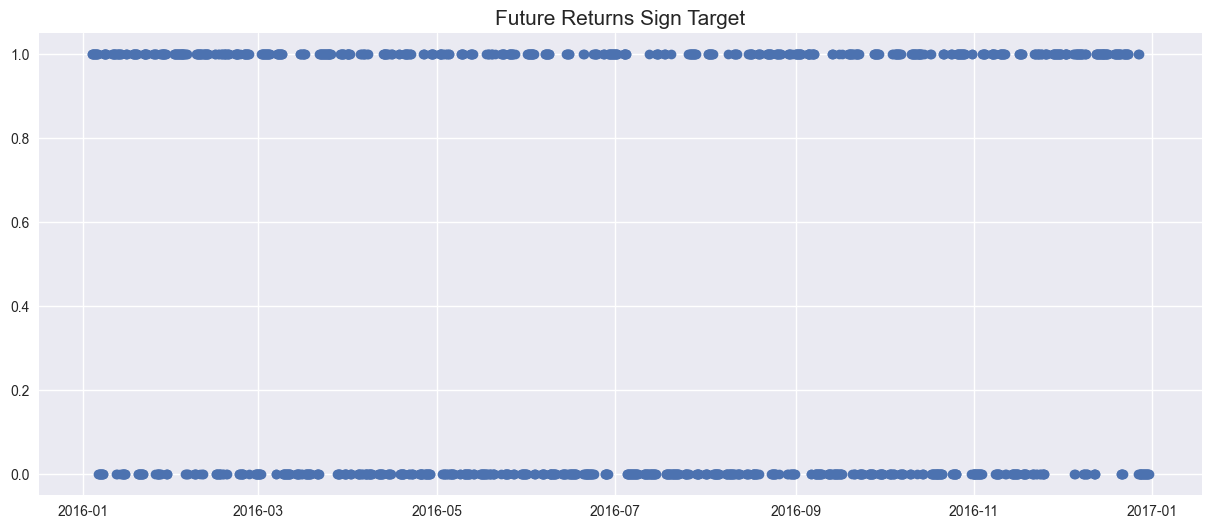

In [4]:
plt.figure(figsize=(15,6))
plt.plot(df["label"], "o")
plt.title("Future Returns Sign Target", size=15)
plt.show()

<br>

## **Quantile Label**

The `quantile_label` function creates a **multi-class target** based on quantiles.

- Assigns a **positive label** to values above a certain quantile (e.g., the 67th percentile).
- Assigns a **negative label** to values below a lower quantile (e.g., the 33rd percentile).
- Assigns a **neutral label** for values in between.

**WARNING**: When using quantile-based targets, always compute the **quantile thresholds on the training set only**, and apply them to the test set to generate labels. Computing quantiles on the full dataset would introduce a **look-ahead bias**, leaking future information into your model.

In [5]:
df["pct_change"] = df["close"].pct_change(1)

In [6]:
# Basic call
df["label"] = te.directional.quantile_label(df, col='pct_change', upper_quantile_level=0.67, lower_quantile_level=0.33)
df["label"]

time
2016-01-04 00:00:00    0
2016-01-04 04:00:00   -1
2016-01-04 08:00:00    1
2016-01-04 12:00:00   -1
2016-01-04 16:00:00    1
                      ..
2016-12-30 04:00:00   -1
2016-12-30 08:00:00    0
2016-12-30 12:00:00   -1
2016-12-30 16:00:00   -1
2016-12-30 20:00:00   -1
Name: label, Length: 1548, dtype: int64

In [7]:
# Train set call
df["label"], q_high, q_low = te.directional.quantile_label(df, col='pct_change', upper_quantile_level=0.80, lower_quantile_level=0.20, return_thresholds=True)
print(q_high, q_low)
df["label"]

0.0011974472411912186 -0.0012601039843373794


time
2016-01-04 00:00:00    0
2016-01-04 04:00:00    0
2016-01-04 08:00:00    1
2016-01-04 12:00:00   -1
2016-01-04 16:00:00    0
                      ..
2016-12-30 04:00:00    0
2016-12-30 08:00:00    0
2016-12-30 12:00:00    0
2016-12-30 16:00:00    0
2016-12-30 20:00:00   -1
Name: label, Length: 1548, dtype: int64

In [8]:
# Test set call
df["label"] = te.directional.quantile_label(df, col='pct_change', q_high=q_high, q_low=q_low)
df["label"]

time
2016-01-04 00:00:00    0
2016-01-04 04:00:00    0
2016-01-04 08:00:00    1
2016-01-04 12:00:00   -1
2016-01-04 16:00:00    0
                      ..
2016-12-30 04:00:00    0
2016-12-30 08:00:00    0
2016-12-30 12:00:00    0
2016-12-30 16:00:00    0
2016-12-30 20:00:00   -1
Name: label, Length: 1548, dtype: int64

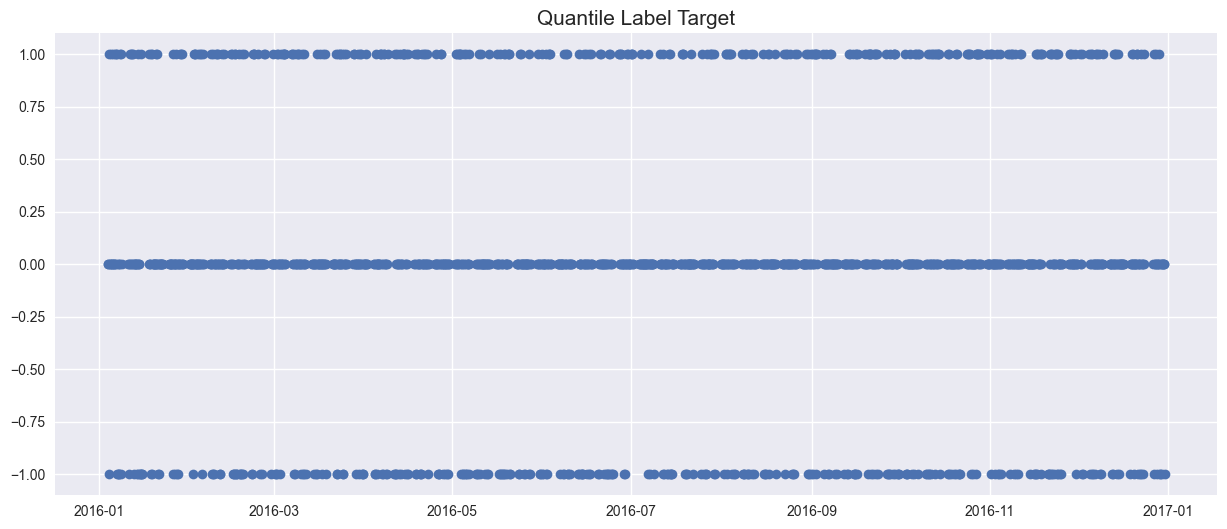

In [9]:
plt.figure(figsize=(15,6))
plt.plot(df["label"], "o")
plt.title("Quantile Label Target", size=15)
plt.show()

<br>

## **Double Barrier Labeling**

The `double_barrier_labeling` function transforms the **continuous time-to-barrier** output into a **classification target**.  
It assigns a **discrete label** depending on whether the price hit the **Take Profit (TP)** or **Stop Loss (SL)** level first.

This method is particularly useful for building **binary classifiers** or **directional models** in event-based trading strategies.

<br>

**WARNINGS "⏱ Time-based requirement"**
Like the continuous version, this method **requires**:

- A **DatetimeIndex** (named `'time'`).
- Two timestamp columns: `high_time` and `low_time`, indicating **when the high and low occurred**.

These allow the function to infer the correct sequence of TP/SL hits with **high precision**.

In [10]:
# Import a dataset to test the next functions more easily
from quantreo.datasets import load_generated_ohlcv_with_time
df = load_generated_ohlcv_with_time()
df = df.loc["2016"]

# Show the data
df

,open,high,low,close,volume,low_time,high_time
time,,,,,,,
2016-01-04 00:00:00,104.944241,105.312073,104.929735,105.232289,576.805768,2016-01-04 03:21:00,2016-01-04 00:23:00
2016-01-04 04:00:00,105.233361,105.252139,105.047564,105.149357,485.696723,2016-01-04 04:15:00,2016-01-04 07:48:00
2016-01-04 08:00:00,105.159851,105.384745,105.141110,105.330306,403.969745,2016-01-04 09:07:00,2016-01-04 10:21:00
2016-01-04 12:00:00,105.330306,105.505799,104.894155,104.923404,1436.917324,2016-01-04 15:50:00,2016-01-04 12:01:00
2016-01-04 16:00:00,104.914147,105.023293,104.913252,105.014347,1177.672605,2016-01-04 18:22:00,2016-01-04 16:09:00
...,...,...,...,...,...,...,...
2016-12-30 04:00:00,103.632257,103.711884,103.495896,103.564574,563.932484,2016-12-30 05:34:00,2016-12-30 04:00:00
2016-12-30 08:00:00,103.564574,103.629321,103.555581,103.616731,697.707475,2016-12-30 10:00:00,2016-12-30 11:59:00
2016-12-30 12:00:00,103.615791,103.628165,103.496810,103.515847,1768.926665,2016-12-30 14:57:00,2016-12-30 12:00:00


In [12]:
df["label"] = te.directional.double_barrier_labeling(df, open_col="open", high_col="high", low_col="low", high_time_col="high_time",
    low_time_col="low_time", tp=0.015, sl=-0.015, buy=True)

100%|█████████████████████████████████████| 1548/1548 [00:00<00:00, 4139.89it/s]


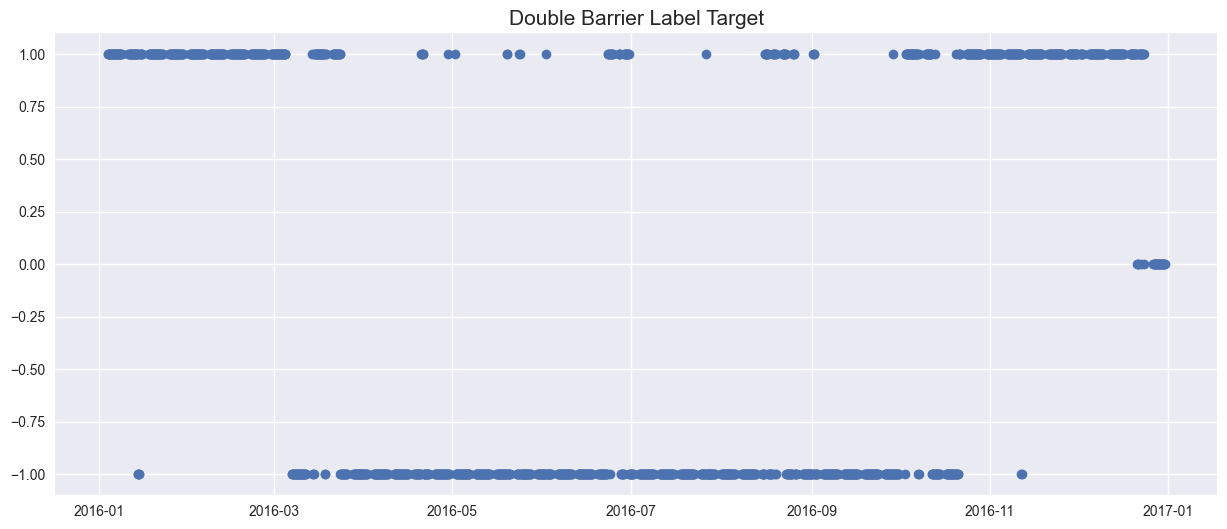

In [14]:
plt.figure(figsize=(15,6))
plt.plot(df["label"], "o")
plt.title("Double Barrier Label Target", size=15)
plt.show()

<br>

## **Triple Barrier Labeling**

The `triple_barrier_labeling` function generates **discrete classification labels** based on **three criteria**:

- A **Take Profit (TP)** level,
- A **Stop Loss (SL)** level,
- A **maximum holding duration** (in hours).

It extends the **double barrier** approach by assigning a **neutral label (0)** when neither barrier is reached within a given time limit.

This target is especially useful in **backtesting** and **reinforcement learning**, where decisions depend not only on price movement but also on **timing constraints**.

<br>

**WARNINGS "⏱ Time-based requirement"**
Like the continuous version, this method **requires**:

- A **DatetimeIndex** (named `'time'`).
- Two timestamp columns: `high_time` and `low_time`, indicating **when the high and low occurred**.

These allow the function to infer the correct sequence of TP/SL hits with **high precision**.

In [15]:
df["label"] = te.directional.triple_barrier_labeling(df, 500, open_col="open", high_col="high", low_col="low", high_time_col="high_time",
    low_time_col="low_time", tp=0.015, sl=-0.015, buy=True)

100%|███████████████████████████████████| 1548/1548 [00:00<00:00, 553849.92it/s]


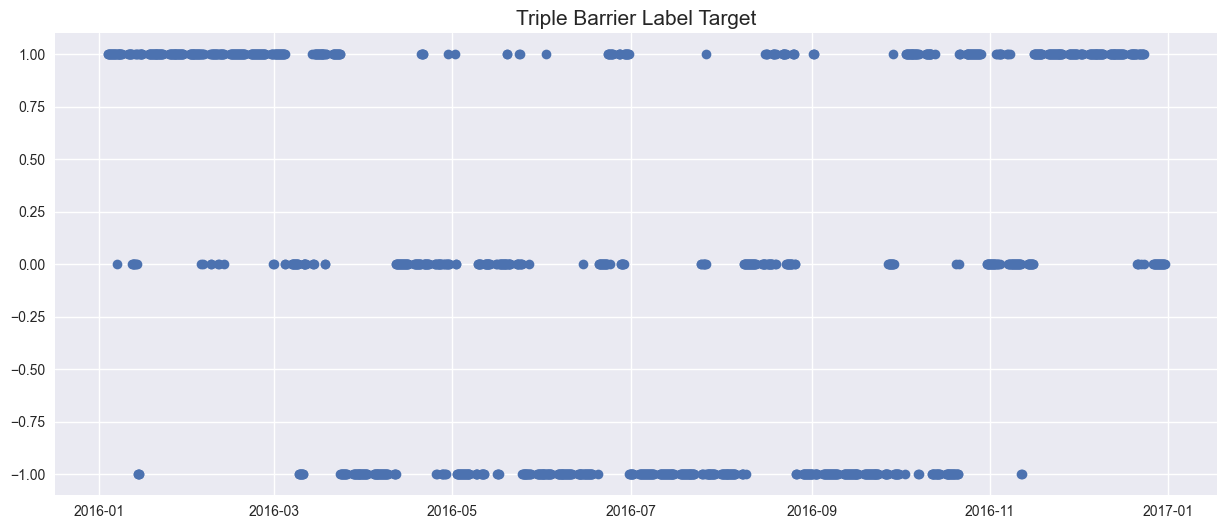

In [17]:
plt.figure(figsize=(15,6))
plt.plot(df["label"], "o")
plt.title("Triple Barrier Label Target", size=15)
plt.show()